## Load data

In [ ]:
import csv


data1 = []
with open('/content/data_1.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)  # Skip the header row
    for row in reader:
        cleaned_row = [float(x) for x in row if x]
        if cleaned_row:
            data1.append(cleaned_row)

data2 = []
with open('/content/data_2.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)  # Skip the header row
    for row in reader:
        cleaned_row = [float(x) for x in row if x]
        if cleaned_row:
            data2.append(cleaned_row)

print(f"Loaded {len(data1)} data points from data_1.csv")
print(f"Loaded {len(data2)} data points from data_2.csv")

Loaded 700 data points from data_1.csv
Loaded 300 data points from data_2.csv


## Distance function

In [4]:
import math

def euclidean_distance(point1, point2):
  """Calculates the Euclidean distance between two data points.

  Args:
    point1: A list or tuple of numerical values representing the first data point.
    point2: A list or tuple of numerical values representing the second data point.

  Returns:
    The Euclidean distance between the two points.
  """
  squared_differences_sum = sum([(p1 - p2) ** 2 for p1, p2 in zip(point1, point2)])
  return math.sqrt(squared_differences_sum)

# Example usage (optional, for testing)
# point_a = [1, 2]
# point_b = [4, 6]
# distance = euclidean_distance(point_a, point_b)
# print(f"The Euclidean distance between {point_a} and {point_b} is: {distance}")

## Region query


In [5]:
def region_query(data, p, eps):

  neighbors = []
  for i in range(len(data)):
    if euclidean_distance(data[p], data[i]) <= eps:
      neighbors.append(i)
  return neighbors

## Expand cluster


In [6]:
from collections import deque

def expand_cluster(data, p, neighbors, cluster_label, eps, min_pts, visited):

    cluster = []
    cluster.append(p)
    visited[p] = True

    queue = deque(neighbors)

    while queue:
        current_point_index = queue.popleft()

        if not visited[current_point_index]:
            visited[current_point_index] = True
            current_neighbors = region_query(data, current_point_index, eps)

            if len(current_neighbors) >= min_pts:
                for neighbor in current_neighbors:
                    if not visited[neighbor]:
                        queue.append(neighbor)

            cluster.append(current_point_index)

    return cluster


## Db-scan algorithm


In [7]:
import numpy as np

def dbscan(data, eps, min_pts):

  n_points = len(data)
  visited = [False] * n_points
  labels = [-1] * n_points  # -1 indicates unclassified or noise
  cluster_label_counter = 0

  for i in range(n_points):
    if visited[i]:
      continue

    visited[i] = True
    neighbors = region_query(data, i, eps)

    if len(neighbors) < min_pts:
      labels[i] = -1  # Mark as noise (initially unclassified, confirmed as noise later if not part of a cluster)
    else:
      # This is a core point, start a new cluster
      cluster = expand_cluster(data, i, neighbors, cluster_label_counter, eps, min_pts, visited)
      for point_index in cluster:
          labels[point_index] = cluster_label_counter
      cluster_label_counter += 1

  # Re-evaluate noise points that might have been visited but not assigned to a cluster
  for i in range(n_points):
      if labels[i] == -1 and visited[i] and len(region_query(data, i, eps)) < min_pts:
           labels[i] = -1 # Confirm as noise

  return labels


## Apply to data


In [16]:
# Define appropriate values for eps and min_pts for data1 and data2
# These values are examples and may need tuning based on the data
eps1 = 0.1
min_pts1 = 3

eps2 = 0.3
min_pts2 = 5

# Apply DB-Scan to data1
labels1 = dbscan(data1, eps1, min_pts1)

# Apply DB-Scan to data2
labels2 = dbscan(data2, eps2, min_pts2)

## Visualize results

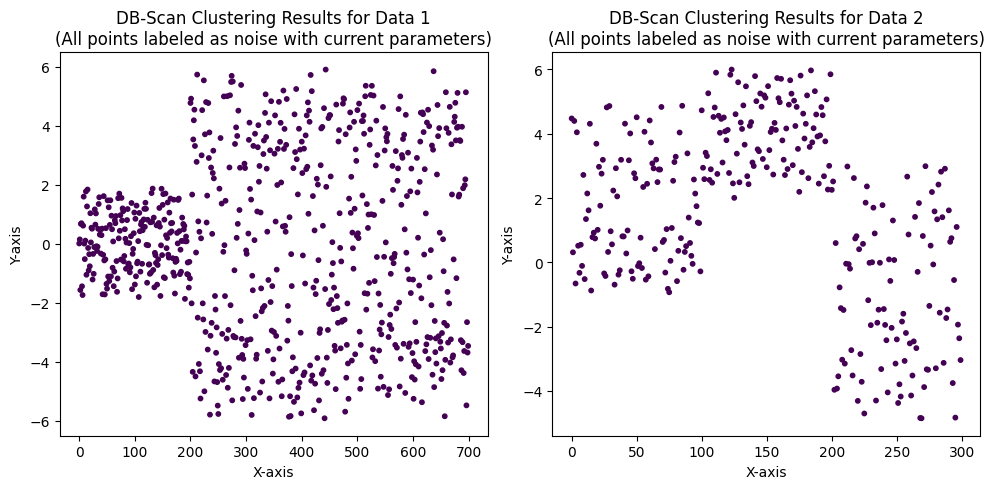

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Convert data lists to numpy arrays for easier indexing
data1_np = np.array(data1)
data2_np = np.array(data2)

# Create scatter plot for data1
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.scatter(data1_np[:, 0], data1_np[:, 1], c=labels1, cmap='viridis', marker='o', s=10)
plt.title("DB-Scan Clustering Results for Data 1\n(All points labeled as noise with current parameters)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Create scatter plot for data2
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.scatter(data2_np[:, 0], data2_np[:, 1], c=labels2, cmap='viridis', marker='o', s=10)
plt.title("DB-Scan Clustering Results for Data 2\n(All points labeled as noise with current parameters)")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

plt.tight_layout()
plt.show()